# Data Access

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import numpy as np
import matplotlib.image as mpimg
import os
from os import listdir
from sklearn.datasets import load_files

from os.path import isfile, join
from random import sample
from tqdm.notebook import tqdm
from keras.utils.np_utils import to_categorical   
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import array_to_img, img_to_array, load_img


Using TensorFlow backend.


In [2]:
def load_data(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels

In [3]:
#read data

data = 'C:/Users/Zhenkun/Desktop/GU/590/final_project/data_part'
x, y, labels = load_data(data)


In [4]:
#split data

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=1)


In [5]:
# change type

def image_to_array(files):
    images_as_array=[]
    for file in files:
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

In [6]:
X_train = np.array(image_to_array(X_train))
X_valid = np.array(image_to_array(X_valid))
X_test = np.array(image_to_array(X_test))

In [7]:
X_train=np.asarray(X_train).astype('float32')/255
y_train=np.asarray(y_train).reshape(-1,1)
y_train_cat = to_categorical(y_train, num_classes=10)
print((X_train.shape,y_train_cat.shape))

((1039, 224, 224, 3), (1039, 10))


In [8]:
X_test = np.asarray(X_test).astype('float32')/255
y_test = np.asarray(y_test).reshape(-1,1)
y_test_cat = to_categorical(y_test, num_classes=10)
print((X_test.shape,y_test_cat.shape))

((325, 224, 224, 3), (325, 10))


In [9]:
X_valid = np.asarray(X_valid).astype('float32')/255
y_valid = np.asarray(y_valid).reshape(-1,1)
y_valid_cat = to_categorical(y_valid, num_classes=10)
print((X_valid.shape,y_valid_cat.shape))

((260, 224, 224, 3), (260, 10))


# VGG19


In [32]:
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.applications import VGG19 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from tensorflow import keras
from tensorflow.keras.applications import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import TensorBoard
import tensorflow
import tensorflow.keras as tfk
from keras.callbacks import ModelCheckpoint, EarlyStopping
tfkl = tfk.layers


In [33]:
# add data augmentation

train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1)
valid_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1)
test_generator = ImageDataGenerator(rotation_range=2, horizontal_flip= True, zoom_range=.1)

train_generator.fit(X_train)
test_generator.fit(X_test)
valid_generator.fit(X_valid)

In [34]:
# use vgg19 model

base_model=VGG19(include_top=False, weights = 'imagenet', input_shape = (224,224,3), classes = y_test_cat.shape[1])

In [35]:
#add layers and compile model

VGG19 = tfk.Sequential()

VGG19.add(base_model)
for layer in VGG19.layers:
    layer.trainable = False
VGG19.add(tfkl.Dense(128,activation=('relu')))
VGG19.add(tfkl.GlobalMaxPooling2D())
VGG19.add(tfkl.Dense(10,activation=('softmax')))
VGG19.compile(optimizer=tfk.optimizers.Adam(),
              loss=tfk.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
VGG19.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
dense_6 (Dense)              (None, 7, 7, 128)         65664     
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
Total params: 20,091,338
Trainable params: 66,954
Non-trainable params: 20,024,384
_________________________________________________________________


In [37]:
#add early stop and train model
Early_sp = EarlyStopping(monitor = 'val_accuracy', patience = 4,restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1)

VGG19_results=VGG19.fit(X_train, y_train_cat,
                        batch_size=32,
                        epochs =20,
                        validation_data=(X_valid, y_valid_cat))
VGG19.save('VGG_model_part')                 

Train on 1039 samples, validate on 260 samples
Epoch 1/20
1039/1039 [==============================] - ETA: 34s - loss: 2.3009 - accuracy: 0.125 - ETA: 18s - loss: 2.3349 - accuracy: 0.062 - ETA: 13s - loss: 2.3267 - accuracy: 0.062 - ETA: 10s - loss: 2.3215 - accuracy: 0.062 - ETA: 9s - loss: 2.3205 - accuracy: 0.075 - ETA: 8s - loss: 2.3204 - accuracy: 0.06 - ETA: 7s - loss: 2.3128 - accuracy: 0.07 - ETA: 7s - loss: 2.3117 - accuracy: 0.07 - ETA: 6s - loss: 2.3038 - accuracy: 0.09 - ETA: 6s - loss: 2.2996 - accuracy: 0.10 - ETA: 5s - loss: 2.2995 - accuracy: 0.10 - ETA: 5s - loss: 2.2971 - accuracy: 0.10 - ETA: 5s - loss: 2.2933 - accuracy: 0.11 - ETA: 4s - loss: 2.2898 - accuracy: 0.12 - ETA: 4s - loss: 2.2882 - accuracy: 0.12 - ETA: 4s - loss: 2.2864 - accuracy: 0.12 - ETA: 4s - loss: 2.2862 - accuracy: 0.12 - ETA: 4s - loss: 2.2850 - accuracy: 0.13 - ETA: 4s - loss: 2.2814 - accuracy: 0.14 - ETA: 3s - loss: 2.2761 - accuracy: 0.15 - ETA: 3s - loss: 2.2701 - accuracy: 0.18 - ETA: 3

1039/1039 [==============================] - ETA: 3s - loss: 1.7495 - accuracy: 0.81 - ETA: 3s - loss: 1.8219 - accuracy: 0.71 - ETA: 3s - loss: 1.7763 - accuracy: 0.77 - ETA: 3s - loss: 1.7821 - accuracy: 0.76 - ETA: 3s - loss: 1.7531 - accuracy: 0.78 - ETA: 3s - loss: 1.7824 - accuracy: 0.75 - ETA: 3s - loss: 1.7929 - accuracy: 0.74 - ETA: 3s - loss: 1.7899 - accuracy: 0.74 - ETA: 3s - loss: 1.7689 - accuracy: 0.76 - ETA: 3s - loss: 1.7696 - accuracy: 0.76 - ETA: 3s - loss: 1.7594 - accuracy: 0.77 - ETA: 3s - loss: 1.7592 - accuracy: 0.77 - ETA: 3s - loss: 1.7782 - accuracy: 0.75 - ETA: 3s - loss: 1.7758 - accuracy: 0.75 - ETA: 3s - loss: 1.7795 - accuracy: 0.75 - ETA: 3s - loss: 1.7730 - accuracy: 0.75 - ETA: 2s - loss: 1.7708 - accuracy: 0.76 - ETA: 2s - loss: 1.7645 - accuracy: 0.77 - ETA: 2s - loss: 1.7750 - accuracy: 0.75 - ETA: 2s - loss: 1.7790 - accuracy: 0.75 - ETA: 2s - loss: 1.7758 - accuracy: 0.75 - ETA: 2s - loss: 1.7786 - accuracy: 0.75 - ETA: 2s - loss: 1.7807 - accura

1039/1039 [==============================] - ETA: 3s - loss: 1.5034 - accuracy: 1.00 - ETA: 3s - loss: 1.6161 - accuracy: 0.93 - ETA: 3s - loss: 1.6061 - accuracy: 0.93 - ETA: 3s - loss: 1.6542 - accuracy: 0.90 - ETA: 3s - loss: 1.6709 - accuracy: 0.87 - ETA: 3s - loss: 1.6740 - accuracy: 0.87 - ETA: 3s - loss: 1.6674 - accuracy: 0.88 - ETA: 3s - loss: 1.6694 - accuracy: 0.87 - ETA: 3s - loss: 1.6759 - accuracy: 0.86 - ETA: 3s - loss: 1.6781 - accuracy: 0.85 - ETA: 3s - loss: 1.6768 - accuracy: 0.85 - ETA: 3s - loss: 1.6763 - accuracy: 0.84 - ETA: 3s - loss: 1.6708 - accuracy: 0.86 - ETA: 3s - loss: 1.6790 - accuracy: 0.84 - ETA: 3s - loss: 1.6784 - accuracy: 0.85 - ETA: 3s - loss: 1.6816 - accuracy: 0.84 - ETA: 2s - loss: 1.6773 - accuracy: 0.84 - ETA: 2s - loss: 1.6711 - accuracy: 0.85 - ETA: 2s - loss: 1.6657 - accuracy: 0.85 - ETA: 2s - loss: 1.6654 - accuracy: 0.85 - ETA: 2s - loss: 1.6589 - accuracy: 0.86 - ETA: 2s - loss: 1.6579 - accuracy: 0.86 - ETA: 2s - loss: 1.6601 - accura

1039/1039 [==============================] - ETA: 3s - loss: 1.4896 - accuracy: 1.00 - ETA: 3s - loss: 1.5067 - accuracy: 1.00 - ETA: 3s - loss: 1.5147 - accuracy: 0.97 - ETA: 3s - loss: 1.5203 - accuracy: 0.98 - ETA: 3s - loss: 1.5177 - accuracy: 0.98 - ETA: 3s - loss: 1.5224 - accuracy: 0.98 - ETA: 3s - loss: 1.5293 - accuracy: 0.98 - ETA: 3s - loss: 1.5231 - accuracy: 0.98 - ETA: 3s - loss: 1.5208 - accuracy: 0.98 - ETA: 3s - loss: 1.5288 - accuracy: 0.98 - ETA: 3s - loss: 1.5266 - accuracy: 0.98 - ETA: 3s - loss: 1.5295 - accuracy: 0.98 - ETA: 3s - loss: 1.5272 - accuracy: 0.98 - ETA: 3s - loss: 1.5292 - accuracy: 0.98 - ETA: 2s - loss: 1.5355 - accuracy: 0.97 - ETA: 2s - loss: 1.5362 - accuracy: 0.96 - ETA: 2s - loss: 1.5362 - accuracy: 0.96 - ETA: 2s - loss: 1.5352 - accuracy: 0.96 - ETA: 2s - loss: 1.5403 - accuracy: 0.96 - ETA: 2s - loss: 1.5389 - accuracy: 0.96 - ETA: 2s - loss: 1.5383 - accuracy: 0.96 - ETA: 2s - loss: 1.5400 - accuracy: 0.96 - ETA: 2s - loss: 1.5394 - accura

1039/1039 [==============================] - ETA: 3s - loss: 1.4846 - accuracy: 1.00 - ETA: 3s - loss: 1.4760 - accuracy: 1.00 - ETA: 3s - loss: 1.4799 - accuracy: 1.00 - ETA: 3s - loss: 1.4782 - accuracy: 1.00 - ETA: 3s - loss: 1.4884 - accuracy: 0.98 - ETA: 3s - loss: 1.4880 - accuracy: 0.98 - ETA: 3s - loss: 1.4879 - accuracy: 0.99 - ETA: 3s - loss: 1.4874 - accuracy: 0.99 - ETA: 3s - loss: 1.4877 - accuracy: 0.99 - ETA: 3s - loss: 1.4920 - accuracy: 0.98 - ETA: 3s - loss: 1.4967 - accuracy: 0.98 - ETA: 3s - loss: 1.4966 - accuracy: 0.98 - ETA: 3s - loss: 1.5031 - accuracy: 0.97 - ETA: 3s - loss: 1.5021 - accuracy: 0.97 - ETA: 3s - loss: 1.5001 - accuracy: 0.97 - ETA: 2s - loss: 1.4985 - accuracy: 0.98 - ETA: 2s - loss: 1.4967 - accuracy: 0.98 - ETA: 2s - loss: 1.4984 - accuracy: 0.97 - ETA: 2s - loss: 1.4981 - accuracy: 0.98 - ETA: 2s - loss: 1.4972 - accuracy: 0.98 - ETA: 2s - loss: 1.4983 - accuracy: 0.97 - ETA: 2s - loss: 1.4971 - accuracy: 0.98 - ETA: 2s - loss: 1.4969 - accura

1039/1039 [==============================] - ETA: 3s - loss: 1.5261 - accuracy: 0.93 - ETA: 3s - loss: 1.5083 - accuracy: 0.96 - ETA: 3s - loss: 1.4951 - accuracy: 0.97 - ETA: 3s - loss: 1.4891 - accuracy: 0.98 - ETA: 3s - loss: 1.4862 - accuracy: 0.98 - ETA: 3s - loss: 1.4832 - accuracy: 0.98 - ETA: 3s - loss: 1.4814 - accuracy: 0.99 - ETA: 3s - loss: 1.4793 - accuracy: 0.99 - ETA: 3s - loss: 1.4784 - accuracy: 0.99 - ETA: 3s - loss: 1.4785 - accuracy: 0.99 - ETA: 3s - loss: 1.4781 - accuracy: 0.99 - ETA: 3s - loss: 1.4774 - accuracy: 0.99 - ETA: 3s - loss: 1.4777 - accuracy: 0.99 - ETA: 3s - loss: 1.4774 - accuracy: 0.99 - ETA: 2s - loss: 1.4774 - accuracy: 0.99 - ETA: 2s - loss: 1.4773 - accuracy: 0.99 - ETA: 2s - loss: 1.4800 - accuracy: 0.99 - ETA: 2s - loss: 1.4793 - accuracy: 0.99 - ETA: 2s - loss: 1.4815 - accuracy: 0.99 - ETA: 2s - loss: 1.4807 - accuracy: 0.99 - ETA: 2s - loss: 1.4806 - accuracy: 0.99 - ETA: 2s - loss: 1.4801 - accuracy: 0.99 - ETA: 2s - loss: 1.4797 - accura

1039/1039 [==============================] - ETA: 3s - loss: 1.4722 - accuracy: 1.00 - ETA: 3s - loss: 1.4690 - accuracy: 1.00 - ETA: 3s - loss: 1.4678 - accuracy: 1.00 - ETA: 3s - loss: 1.4677 - accuracy: 1.00 - ETA: 3s - loss: 1.4675 - accuracy: 1.00 - ETA: 3s - loss: 1.4679 - accuracy: 1.00 - ETA: 3s - loss: 1.4678 - accuracy: 1.00 - ETA: 3s - loss: 1.4810 - accuracy: 0.98 - ETA: 3s - loss: 1.4793 - accuracy: 0.98 - ETA: 3s - loss: 1.4780 - accuracy: 0.98 - ETA: 3s - loss: 1.4769 - accuracy: 0.98 - ETA: 3s - loss: 1.4763 - accuracy: 0.98 - ETA: 3s - loss: 1.4754 - accuracy: 0.99 - ETA: 3s - loss: 1.4795 - accuracy: 0.98 - ETA: 3s - loss: 1.4787 - accuracy: 0.98 - ETA: 3s - loss: 1.4780 - accuracy: 0.98 - ETA: 3s - loss: 1.4802 - accuracy: 0.98 - ETA: 2s - loss: 1.4795 - accuracy: 0.98 - ETA: 2s - loss: 1.4789 - accuracy: 0.98 - ETA: 2s - loss: 1.4783 - accuracy: 0.98 - ETA: 2s - loss: 1.4788 - accuracy: 0.98 - ETA: 2s - loss: 1.4782 - accuracy: 0.98 - ETA: 2s - loss: 1.4782 - accura

1039/1039 [==============================] - ETA: 3s - loss: 1.4653 - accuracy: 1.00 - ETA: 3s - loss: 1.4652 - accuracy: 1.00 - ETA: 3s - loss: 1.4649 - accuracy: 1.00 - ETA: 3s - loss: 1.4649 - accuracy: 1.00 - ETA: 3s - loss: 1.4648 - accuracy: 1.00 - ETA: 3s - loss: 1.4745 - accuracy: 0.98 - ETA: 3s - loss: 1.4735 - accuracy: 0.99 - ETA: 3s - loss: 1.4722 - accuracy: 0.99 - ETA: 3s - loss: 1.4715 - accuracy: 0.99 - ETA: 3s - loss: 1.4713 - accuracy: 0.99 - ETA: 3s - loss: 1.4708 - accuracy: 0.99 - ETA: 3s - loss: 1.4705 - accuracy: 0.99 - ETA: 3s - loss: 1.4704 - accuracy: 0.99 - ETA: 3s - loss: 1.4701 - accuracy: 0.99 - ETA: 3s - loss: 1.4698 - accuracy: 0.99 - ETA: 3s - loss: 1.4695 - accuracy: 0.99 - ETA: 3s - loss: 1.4695 - accuracy: 0.99 - ETA: 2s - loss: 1.4692 - accuracy: 0.99 - ETA: 2s - loss: 1.4693 - accuracy: 0.99 - ETA: 2s - loss: 1.4691 - accuracy: 0.99 - ETA: 2s - loss: 1.4689 - accuracy: 0.99 - ETA: 2s - loss: 1.4689 - accuracy: 0.99 - ETA: 2s - loss: 1.4686 - accura

1039/1039 [==============================] - ETA: 3s - loss: 1.5207 - accuracy: 0.93 - ETA: 3s - loss: 1.4927 - accuracy: 0.96 - ETA: 3s - loss: 1.4838 - accuracy: 0.97 - ETA: 3s - loss: 1.4791 - accuracy: 0.98 - ETA: 3s - loss: 1.4759 - accuracy: 0.98 - ETA: 3s - loss: 1.4737 - accuracy: 0.98 - ETA: 3s - loss: 1.4801 - accuracy: 0.98 - ETA: 3s - loss: 1.4781 - accuracy: 0.98 - ETA: 3s - loss: 1.4765 - accuracy: 0.98 - ETA: 3s - loss: 1.4755 - accuracy: 0.98 - ETA: 3s - loss: 1.4747 - accuracy: 0.98 - ETA: 3s - loss: 1.4739 - accuracy: 0.98 - ETA: 3s - loss: 1.4731 - accuracy: 0.99 - ETA: 3s - loss: 1.4726 - accuracy: 0.99 - ETA: 3s - loss: 1.4720 - accuracy: 0.99 - ETA: 3s - loss: 1.4717 - accuracy: 0.99 - ETA: 2s - loss: 1.4712 - accuracy: 0.99 - ETA: 2s - loss: 1.4708 - accuracy: 0.99 - ETA: 2s - loss: 1.4705 - accuracy: 0.99 - ETA: 2s - loss: 1.4703 - accuracy: 0.99 - ETA: 2s - loss: 1.4700 - accuracy: 0.99 - ETA: 2s - loss: 1.4699 - accuracy: 0.99 - ETA: 2s - loss: 1.4698 - accura

1039/1039 [==============================] - ETA: 3s - loss: 1.4649 - accuracy: 1.00 - ETA: 3s - loss: 1.4909 - accuracy: 0.96 - ETA: 3s - loss: 1.4824 - accuracy: 0.97 - ETA: 3s - loss: 1.4775 - accuracy: 0.98 - ETA: 3s - loss: 1.4750 - accuracy: 0.98 - ETA: 3s - loss: 1.4732 - accuracy: 0.98 - ETA: 3s - loss: 1.4722 - accuracy: 0.99 - ETA: 3s - loss: 1.4714 - accuracy: 0.99 - ETA: 3s - loss: 1.4705 - accuracy: 0.99 - ETA: 3s - loss: 1.4698 - accuracy: 0.99 - ETA: 3s - loss: 1.4692 - accuracy: 0.99 - ETA: 3s - loss: 1.4687 - accuracy: 0.99 - ETA: 3s - loss: 1.4684 - accuracy: 0.99 - ETA: 3s - loss: 1.4681 - accuracy: 0.99 - ETA: 3s - loss: 1.4678 - accuracy: 0.99 - ETA: 2s - loss: 1.4676 - accuracy: 0.99 - ETA: 2s - loss: 1.4676 - accuracy: 0.99 - ETA: 2s - loss: 1.4673 - accuracy: 0.99 - ETA: 2s - loss: 1.4672 - accuracy: 0.99 - ETA: 2s - loss: 1.4669 - accuracy: 0.99 - ETA: 2s - loss: 1.4668 - accuracy: 0.99 - ETA: 2s - loss: 1.4666 - accuracy: 0.99 - ETA: 2s - loss: 1.4665 - accura

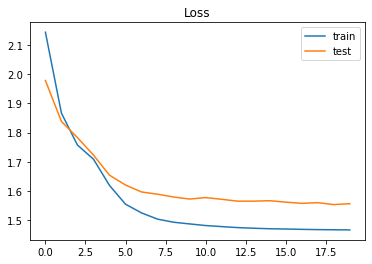

In [38]:
#check the loss

plt.title('Loss')
plt.plot(VGG19_results.history['loss'], label='train')
plt.plot(VGG19_results.history['val_loss'], label='test')
plt.legend()
plt.show()

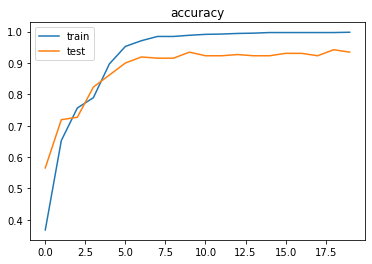

In [39]:
#check the accuracy

plt.title('accuracy')
plt.plot(VGG19_results.history['accuracy'], label='train')
plt.plot(VGG19_results.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [40]:
# check the test accuracy
from sklearn.metrics import accuracy_score 

pred = VGG19.predict(X_test)
pred = pred.argmax(axis=1)
acc = accuracy_score(y_test, pred) 


In [41]:
print('Accuracy is',acc)

Accuracy is 0.9415384615384615


Confusion matrix, without normalization


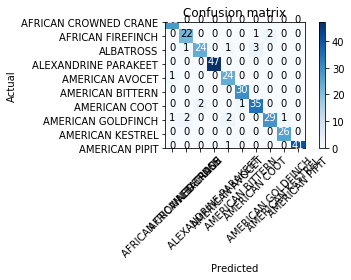

In [42]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()

cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes = labels)